In [2]:
%matplotlib inline  

In [1]:
import scipy.io as sio
import scipy.signal as scs
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as npml


### functions definition

In [6]:
def reconstruct_rf_img(rf, x_grid, z_grid,
                       pitch, fs, fc, c,
                       tx_aperture, tx_focus, tx_angle,
                       n_pulse_periods, tx_mode='lin', n_first_samples=0,
                       ):

    """
    Function for image reconstruction using delay-and-sum approach.

    :param rf: 3D array of rf signals before beamforming
    :param x_grid: vector of pixel x coordinates [m]
    :param z_grid: vector of pixel z coordinates [m]
    :param pitch: the distance between contiguous elements [m]
    :param fs: sampling frequency [Hz]
    :param fc: carrier frequency [Hz]
    :param n_pulse_periods: the length of the pulse in periods
    :param n_first_samples: samples recorded before transmission
    :param c: assumed speed of sound [m/s]
    :param tx_mode: imaging mode - lin (classical),
                                   sta (synthetic transmit aperture)
                                   pwi (plane wave imaging)
    :param tx_focus: transmit focus [m]
    :param tx_angle: transmit angle [radians]
    :return: rf beamformed image

    """

    # making x and z_grid 'vertical vector' (should be more user friendly in future!)
    temp = z_grid[np.newaxis]
    z_grid = temp.T

    # getting some size parameters
    n_samples, n_channels, n_transmissions  = rf.shape
    z_size = max(z_grid.shape)
    x_size = max(x_grid.shape)

    # probe/transducer width
    probe_width = (n_channels-1)*pitch

    # x coordinate of transducer elements
    element_xcoord = np.linspace(-probe_width/2, probe_width/2, n_channels)

    # initial delays [s]
    delay0 = n_first_samples/fs
    burst_factor = 0.5*n_pulse_periods/fc
    is_lin_or_sta = tx_mode == 'lin' or tx_mode == 'sta'
    if is_lin_or_sta and tx_focus > 0:
        focus_delay = (np.sqrt(((tx_aperture-1)*pitch/2)**2 + tx_focus**2)
                       - tx_focus)/c
    else:
        focus_delay = 0

    init_delay = focus_delay + burst_factor - delay0

    # Delay & Sum
    # add zeros as last samples.
    # If a sample is out of range 1: nSamp, then use the sample no.nSamp + 1 which is 0.
    # to be checked if it is faster than irregular memory access.
    tail = np.zeros((1, n_channels, n_transmissions))
    rf = np.concatenate((rf, tail))

    # buffers allocation
    rf_tx = np.zeros((z_size, x_size, n_transmissions))
    weight_tx = np.zeros((z_size, x_size, n_transmissions))

    # loop over transmissions
    for itx in range(0, n_transmissions):

        # calculate tx delays and apodization

        # classical linear scanning
        # (only a narrow stripe is reconstructed  at a time, no tx apodization)
        if tx_mode == 'lin':

            # difference between image point x coordinate and element x coord
            xdifference = np.array(x_grid-element_xcoord[itx])

            # logical indexes of valid x coordinates
            lix_valid = (xdifference > (-pitch/2)) & (xdifference <= (pitch/2))
            n_valid = np.sum(lix_valid)

            # ix_valid = list(np.nonzero(lix_valid))
            tx_distance = npml.repmat(z_grid, 1, n_valid)
            tx_apodization = np.ones((z_size, n_valid))
            # TODO: Should be better image close to the transducer (apodization)

        # synthetic transmit aperture method
        elif tx_mode == 'sta':
            lix_valid = np.ones((x_size), dtype=bool)
            tx_distance = np.sqrt((z_grid - tx_focus)**2
                                + (x_grid - element_xcoord[itx])**2
                          )

            tx_distance = tx_distance*np.sign(z_grid - tx_focus) + tx_focus

            f_number = max(np.append(abs(z_grid - tx_focus), 1e-12))\
                        /abs(x_grid - element_xcoord[itx])*0.5

            tx_apodization = f_number > 2
            

        elif tx_mode == 'pwi':
            lix_valid = np.ones((x_size), dtype=bool)

            if tx_angle[itx] >= 0:
                first_element = 0
            else:
                first_element = n_channels-1


            tx_distance = \
                (x_grid - element_xcoord[first_element]) * np.sin(tx_angle[itx])\
                + z_grid * np.cos(tx_angle[itx])

            r1 = (x_grid - element_xcoord[0]) * np.cos(tx_angle[itx])\
                 - z_grid * np.sin(tx_angle[itx])

            r2 = (x_grid - element_xcoord[-1]) * np.cos(tx_angle[itx])\
                 - z_grid * np.sin(tx_angle[itx])

            tx_apodization = (r1 >= 0) & (r2 <= 0)

        else:
            raise ValueError('unknown reconstruction mode!')

            # buffers allocation
        rf_rx = np.zeros((z_size, x_size, n_channels))
        weight_rx = np.zeros((z_size, x_size, n_channels))

        # loop over elements
        for irx in range(0, n_channels):

            # calculate rx delays and apodization
            rx_distance = np.sqrt((x_grid[lix_valid] - element_xcoord[irx])**2
                                  + z_grid**2)
            f_number = abs(z_grid/(x_grid[lix_valid] - element_xcoord[irx])*0.5)
            rx_apodization = f_number > 2

            # calculate total delays [s]
            delays = init_delay + (tx_distance + rx_distance)/c
            

            # calculate sample number to be used in reconstruction
            samples = delays*fs + 1
            

            out_of_range = (0 > samples) | (samples > n_samples-1)
            samples[out_of_range] = n_samples

            # calculate rf samples (interpolated) and apodization weights
            rf_raw_line = rf[:, irx, itx]
            ceil_samples = np.ceil(samples).astype(int)
            floor_samples = np.floor(samples).astype(int)

            rf_rx[:, lix_valid, irx] = rf_raw_line[floor_samples]*(1 - (samples % 1))\
                                       + rf_raw_line[ceil_samples]*(samples % 1)

            weight_rx[:, lix_valid, irx] = tx_apodization * rx_apodization

            # modulate if iq signal is used (to trzeba sprawdzic, bo pisane 'na rybke')
            is_data_complex = np.nonzero(np.imag(rf_rx))[0].size
            if is_data_complex:
                # TODO: przetestowac
                rf_rx[:, lix_valid, irx] = rf_rx[:, lix_valid, irx] \
                                           * np.exp(1j*2*np.pi*fc*delays)
                print('complex data')

        # calculate rf and weights for single tx
        rf_tx[:, :, itx] = np.sum(rf_rx * weight_rx, axis=2)
        weight_tx[:, :, itx] = np.sum(weight_rx, axis=2)

        # show progress
        percentage = round((itx+1)/n_transmissions*1000)/10
        if itx == 0:
            print(percentage, '%', end='')
        elif itx == n_transmissions-1:
            print('\r', percentage, '%')
        else:
            print('\r', percentage, '%', end='')

    # calculate final rf image
    rf_image = np.sum(rf_tx, axis=2)/np.sum(weight_tx, axis=2)

    return rf_image


def load_simulated_data(file, verbose=1):
    """
    The function loads data from simulation
    :param file: path2file/filename
    :param verbose: if 1 data keys are printed
    :return:
    """

    matlab_data = sio.loadmat(file)

    c = matlab_data.get('sos')
    c = np.float(c)

    fc = matlab_data.get('fn')
    fc = np.float(fc)

    fs = matlab_data.get('fs')
    fs = np.float(fs)

    n_elements = matlab_data.get('nElem')
    n_elements = np.int(n_elements)
    


    pulse_periods = matlab_data.get('nPer')
    pulse_periods = np.int(pulse_periods)

    pitch = matlab_data.get('pitch')
    pitch = np.float(pitch)


    if 'txAng' in matlab_data:
        tx_angle = matlab_data.get('txAng')
        tx_angle = np.radians(tx_angle)
        tx_angle = tx_angle.T
        # tx_angle = np.int(tx_angle)
    else:
        tx_angle = 0



    if 'txAp' in matlab_data:
        tx_aperture = matlab_data.get('txAp')
        tx_aperture = np.int(tx_aperture)
    else:
        tx_aperture = 1

    if 'txFoc' in matlab_data:
        tx_focus = matlab_data.get('txFoc')
        tx_focus = np.float(tx_focus)
    else:
        tx_focus = 0


    if 'rfLin' in matlab_data:
        rf = matlab_data.get('rfLin')
        mode = 'lin'
        
    if 'rfPwi' in matlab_data:
        rf = matlab_data.get('rfPwi')
        mode = 'pwi'

    if 'rfSta' in matlab_data:
        rf = matlab_data.get('rfSta')
        mode = 'sta'

    if verbose:
        print('input data keys: ', matlab_data.keys())
        print(' ')
        print(' ')
        print('mode:', mode)
        print('speed of sound: ', c)
        print('sampling frequency: ', fs)
        print('pulse (carrier) frequency: ', fc)
        print('pitch: ', pitch)
        print('aperture length: ', n_elements)
        print('focal length: ', tx_focus)
        print('subaperture length: ', tx_aperture)
        print('transmission angles: ', tx_angle.T)
        print('number of pulse periods: ', pulse_periods)



    return [rf, c, fs, fc, pitch, tx_focus, tx_angle, tx_aperture, n_elements, pulse_periods, mode]

def calculate_envelope(rf):
    """
    The function calculate envelope using hilbert transform
    :param rf:
    :return: envelope image
    """
    envelope = np.abs(scs.hilbert(rf, axis=0))
    return envelope

def make_bmode_image(rf_image, x_grid, y_grid):
    """
    The function for creating b-mode image
    :param rf_image: 2D rf image
    :param x_grid: vector of x coordinates
    :param y_grid: vector of y coordinates
    :return:
    """
    dx=x_grid[1]-x_grid[0]
    dy=y_grid[1]-y_grid[0]

    # calculate envelope
    amplitude_image = calculate_envelope(rf_image)

    # convert do dB
    max_image_value = np.max(amplitude_image)
    bmode_image = np.log10(amplitude_image / max_image_value) * 20

    # calculate ticks and labels
    n_samples, n_lines = rf_image.shape
    image_height = (n_samples - 1)*dy
    image_height = z_grid[-1] - z_grid[0]
    # max_depth = image_depth + depth0
    # max_depth = z_grid[-1]
    # image_width = (n_lines - 1)*dx
    image_width = x_grid[-1] - x_grid[0]
    image_proportion = image_height/image_width

    n_xticks = 4
    n_yticks = round(n_xticks * image_proportion)

    xticks = np.linspace(0, n_lines-1, n_xticks)
    xtickslabels = np.linspace(x_grid[0], x_grid[-1], n_xticks)*1e3
    xtickslabels = np.round(xtickslabels, 1)

    yticks = np.linspace(0, n_samples-1, n_yticks)
    ytickslabels = np.linspace(z_grid[0], z_grid[-1], n_yticks)*1e3
    ytickslabels = np.round(ytickslabels, 1)

    # calculate data aspect for proper image proportions
    data_aspect = dy/dx

    # show the image
    plt.imshow(bmode_image,
                    interpolation='bicubic',
                    aspect=data_aspect,
                    cmap='gray',
                    vmin=-60, vmax=0
                    )

    plt.xticks(xticks, xtickslabels)
    plt.yticks(yticks, ytickslabels)

    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel('[dB]', rotation=90)
    plt.xlabel('[mm]')
    plt.ylabel('[mm]')
    plt.show()


### loading data

In [7]:
# choosing the mode and path to data file

# mode = 'sta'
mode = 'pwi'
# mode = 'lin'

# if mode == 'sta':
#     file = '/media/linuser/data01/praca/us4us/' \
#          'us4us_testData/dataSets02/rfSta_field.mat'
#     print('STA mode')
# elif mode == 'pwi':
#     file = '/media/linuser/data01/praca/us4us/' \
#            'us4us_testData/dataSets02/rfPwi_field.mat'
#     print('PWI mode')
# elif mode == 'lin':
#     file = '/media/linuser/data01/praca/us4us/' \
#            'us4us_testData/dataSets02/rfLin_field.mat'
#     print('classic mode')
# else:
#     raise ValueError('unknown reconstruction mode!')



# ippt
file = '/home/linuser/us4us/usgData/rfPwi_field.mat'


       

# load data
[rf, c, fs, fc, pitch,
tx_focus, tx_angle, tx_aperture,
n_elements, pulse_periods, mode] = load_simulated_data(file, 1)


input data keys:  dict_keys(['__header__', '__version__', '__globals__', 'fn', 'fs', 'nElem', 'nPer', 'pitch', 'rfPwi', 'sos', 'txAng'])
 
 
mode: pwi
speed of sound:  1540.0
sampling frequency:  65000000.0
pulse (carrier) frequency:  5000000.0
pitch:  0.00021
aperture length:  192
focal length:  0
subaperture length:  1
transmission angles:  [[-0.34906584 -0.33161256 -0.31415927 -0.29670596 -0.27925268 -0.2617994
  -0.2443461  -0.2268928  -0.20943952 -0.19198622 -0.17453292 -0.15707964
  -0.13962634 -0.12217305 -0.10471976 -0.08726646 -0.06981317 -0.05235988
  -0.03490658 -0.01745329  0.          0.01745329  0.03490658  0.05235988
   0.06981317  0.08726646  0.10471976  0.12217305  0.13962634  0.15707964
   0.17453292  0.19198622  0.20943952  0.2268928   0.2443461   0.2617994
   0.27925268  0.29670596  0.31415927  0.33161256  0.34906584]]
number of pulse periods:  2


### reconstruction

In [8]:
# define grid for reconstruction (imaged area)
x_grid = np.linspace(-3*1e-3, 3*1e-3, 32)
z_grid = np.linspace(9.5*1e-3, 11.*1e-3, 64)

# reconstruct data
rf_image = reconstruct_rf_img(rf, x_grid, z_grid,
                           pitch, fs, fc, c,
                           tx_aperture, tx_focus, tx_angle,
                           pulse_periods, tx_mode=mode
                           )


 100.0 %


### make image

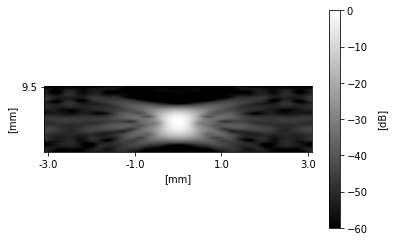

In [10]:
make_bmode_image(rf_image, x_grid, z_grid)